In [1]:
import numpy as np
import torch
from PIL import Image, ImageOps
import time

In [2]:
def normalize(or_array): #min-max normalization...
    ma = torch.max(or_array)
    mi = torch.min(or_array)
    n_array = torch.div(torch.sub(or_array, mi), torch.add(torch.sub(ma,mi),1e-5))
    return n_array     

In [3]:
def lorentz_f(tt):  #lorentz factor...
    import math
    lorentz = []
    lorentz.append(22.366)   
    lorentz.append(7.089)
    for i in range(1,int(tt-1)):
        beta = ((tt - 2) - i) / (tt - 2)
        lorentz.append (1 / math.sqrt(1 - beta**2))
    mlor = sum(lorentz) / len(lorentz)
    # print('mean lorentz:', mlor) #activate if you want to see mean lorentz...
    return mlor, lorentz   #mlor, lorentz: mean lorentz factor and list of lorentz factors for each t sample

In [4]:
def gamma_correction(n_im, time_out):
    p = 0.50  #activation level of gamma_correction...
   
    for ty in range(0,n_im):
        mm = torch.mean(time_out[ty,:,:]) 
        if torch.any(time_out[ty,:,:]<p):
            mmc = (mm + p)
            time_out[ty,:,:]  = torch.pow(time_out[ty,:,:] , (mmc))
    return time_out

In [5]:
def time_shift_color(t_samples,or_image):
        mlor, lorentz = lorentz_f(t_samples)
        row = or_image.shape[1]
        col = or_image.shape[2]
        nim = or_image.shape[3]
        s_dt2 = torch.empty(nim, t_samples, row, col)
        mu_s_dt = torch.zeros(nim,row, col)
        s_dt= torch.empty(nim,t_samples, row, col)
        
        for imn in range(0,nim):
            for t in range(0,t_samples):
                  td = torch.div(t,t_samples) 
                  Idt = torch.sub(or_image[0,:,:,imn], torch.mul(or_image[0,:,:,imn], lorentz[t])) # Delta Idt (Equation 3 in paper)
                  ct_t2 = torch.pow((or_image[0,:,:,imn]*(1-td)),2) #Equation 8 in paper... (delta ct_t)^2
                  s_dt2[imn,t,:,:] =  ct_t2 - Idt # Equation 9 in paper (delta s_dt)^2
                  s_dt[imn,t,:,:] = (s_dt2[imn,t,:,:])
                  s_dt[imn,t,:,:] = normalize(s_dt[imn,t,:,:]) #normalization
                  mu_s_dt[imn,:,:] = torch.add(s_dt[imn,t,:,:], mu_s_dt[imn, :,:]*mlor) #Equation 10... mean with mean Lorentz...
            mu_s_dt[imn,:,:] = torch.div(mu_s_dt[imn,:,:], t_samples) #final mean
            mu_s_dt[imn,:,:] = normalize(mu_s_dt[imn,:,:]) #normalize
        
        # GAMMA CORRECTION #
        final_out = gamma_correction(nim, mu_s_dt)
        return final_out

In [6]:
def time_shift_gray(t_samples,or_image):
        mlor, lorentz = lorentz_f(t_samples)
        row = or_image.shape[1]
        col = or_image.shape[2]
        s_dt2 = torch.empty(t_samples, row, col)
        mu_s_dt = torch.zeros(row, col)
        s_dt= torch.empty(t_samples, row, col)
        for t in range(0, t_samples):
                  td = torch.div(t,t_samples)
                  Idt = torch.sub(or_image[0,:,:], torch.mul(or_image[0,:,:], lorentz[t])) # Delta Idt (Equation 3 in paper)
                  ct_t2 = torch.pow((or_image[0,:,:]*(1-td)),2) #Equation 8 in paper... (delta ct_t)^2
                  s_dt2[t,:,:] =  ct_t2 - Idt  # Equation 9 in paper (delta s_dt)^2
                  s_dt[t,:,:] = (s_dt2[t,:,:])
                  s_dt[t,:,:] = normalize(s_dt[t,:,:]) #normalization
                  mu_s_dt[:,:] = torch.add(s_dt[t,:,:], mu_s_dt[:,:]*mlor) #Equation 10... mean with mean Lorentz...
        mu_s_dt[:,:] = torch.div(mu_s_dt[:,:], t_samples) #final mean
        mu_s_dt[:,:] = normalize(mu_s_dt[:,:]) #normalize

        nim = 0
        final_out = gamma_correction(nim,mu_s_dt)
        return final_out

In [7]:
def write_im_c(a1,b1,c1,name): #saving color image.... 
   # a1,b1,c1 = r, g, c channel respectively...
   sa = 0   
   sa = sa + 1  
   imr = Image.fromarray(np.uint8(a1*255))
   imr = ImageOps.grayscale(imr)
   img = Image.fromarray(np.uint8(b1*255))
   img = ImageOps.grayscale(img)
   imb = Image.fromarray(np.uint8(c1*255))
   imb = ImageOps.grayscale(imb)
   img =Image.merge("RGB",(imr,img,imb))
   imagePathr = ('output' + name)
   img.save(imagePathr)
   display(img)
def write_im_g(a1,name): #saving gray image....
   sa = 0   
   sa = sa + 1  
   img = Image.fromarray(np.uint8(a1*255))
   img = ImageOps.grayscale(img)
   imagePathr = ('output' + name)
   img.save(imagePathr)
   display(img)

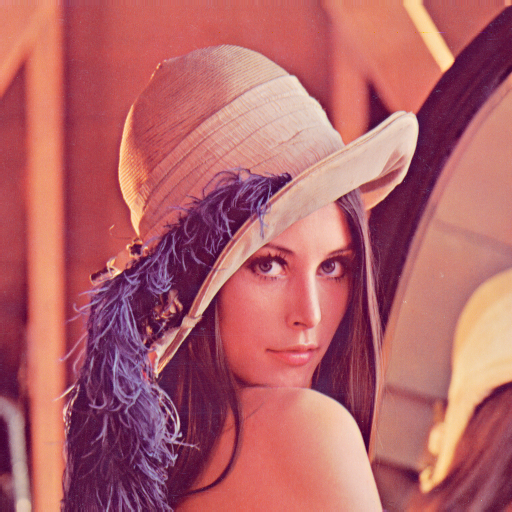

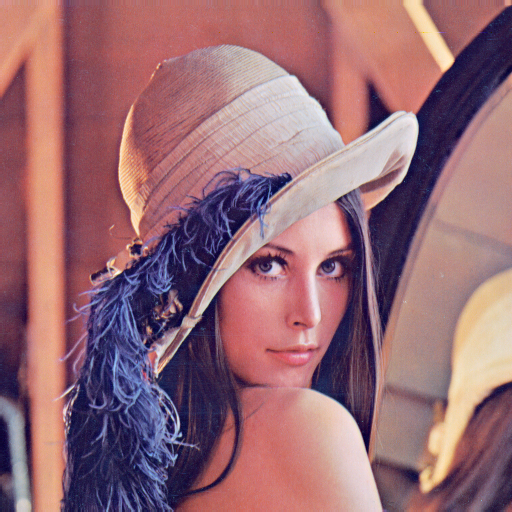

EXECUTION TIME: 0.33155393600463867


In [8]:
ims2 = []
imagef = 'Lena.png' #image file  
 
readImage = Image.open(imagef)   # read image
display(readImage)
readImage  = np.array(readImage)  

if(len(readImage.shape)<3):  # check if it is gray or color...
      im = 'g'
elif len(readImage.shape)==3:
      im = 'c'
readImage = readImage / 255    #normalize image
ims2.append(readImage)    
ims2 = np.array(ims2)

X = torch.from_numpy(ims2) # image as a torch tensor



#################
# time parameter#
#################
n_events = 5 # number of space time events
#################



if im == 'c':
    st = time.time()
    output = time_shift_color(n_events, X) 
    write_im_c(output[0,:,:], output[1,:,:], output[2,:,:], imagef) #send r,g, and b channels to save image   
    et = time.time()
    elapsed_time = et - st
else:
    st = time.time()
    output = time_shift_gray(n_events, X)  
    write_im_g(output, imagef)
    et = time.time()
    elapsed_time = et - st


print('EXECUTION TIME:', elapsed_time)